## Call Center Operations Optimization

### Objective

The objective of this project is to simulate and optimize call center operations using queueing theory. We model customer call arrivals and agent service times to analyze system performance, evaluate staffing requirements, and ensure service quality targets (such as minimizing customer wait times) are met.

In [4]:
import numpy as np , pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

## Step 1:
- 1.Model calls arriving at rate λ per hour (Poisson process) and service times of 1/μ hours (Exponential).

In [5]:
lb = 20 # calls per hour
Mu = 5  # calls served per agent per hour
shift_hours = 8 # shift hours

λ (lambda): Call arrival rate, i.e., 20 calls expected per hour.

μ (mu): Each agent is expected to handle 5 calls per hour.

Shift Length: We simulate events within an 8-hour work period.

In [6]:
np.random.seed(1)

In [7]:
# Time gaps between the events(call ariavals)
inter = np.random.exponential(1/lb,size=int(lb*shift_hours * 1.5)) # It returns random time intervals between events, where shorter intervals are more likely

We use an exponential distribution to generate random time gaps between call arrivals.

This distribution is suitable for modeling events that happen continuously and independently.

We generate more values than expected (1.5×) to ensure we have enough valid arrivals within the shift.



In [8]:
# gives you the exact times (during the shift) when customer calls arrive.
arrivals = np.cumsum(inter) 

arrivals = arrivals[arrivals < shift_hours] 

We calculate the cumulative sum of the time gaps to get the actual times (within the shift) when each call arrives.

We filter out any calls that would have arrived after the 8-hour shift ends.



In [9]:
N = len(arrivals)

This gives the total number of calls that arrived during the shift.

## Step 2
**Simulate an M/M/s queue over an 8-hour shift, tracking each caller’s wait time and queue length**. 

#### Simulating a Call Center with Agents

This function models how calls are handled by a fixed number of agents over an 8-hour work shift. It simulates customer wait times, how many people are in the system at any moment, and how agents serve them using basic queueing logic.

In [10]:
def simulate_time(s):
    np.random.seed(1)
    inter = np.random.exponential(1/lb,size=int(lb*shift_hours * 1.5))
    arrivals = np.cumsum(inter) 
    arrivals = arrivals[arrivals < shift_hours] 
    N = len(arrivals)
    services = np.random.exponential(1/Mu,N)
    next_free = np.zeros(s)
    wait_time = np.zeros(N)
    system_size = np.zeros(N) # 
    dep_times = []
    for i, t in enumerate(arrivals):
        j = np.argmin(next_free) # Find the agent who is available first
        start = max(t,next_free[j]) # start the call when the agent becomes free
        wait_time[i] = start - t #calculate how long the customer waited
        end = start + services[i] # when the service end
        next_free[j] = end # update the agent available
        dep_times.append(end)
    
        system_size[i] = np.sum(np.array(dep_times) > t) # no of customers in the system
    
    return wait_time,system_size    

wait_time[i]: how long caller i waited before being served.

system_size[i]: how many people were in the system when call i arrived.

dep_times: end times of completed services — used to calculate system size.

In [11]:
w1,q1 = simulate_time(s = 1)
print('Wait = ',w1.mean())
print('system_size = ',q1.mean())

Wait =  13.470535006616128
system_size =  65.99386503067484


How increasing the number of agents affects customer wait time.

The average number of people in the system at any moment.

## Step 3.

### Comparing M/M/1 Queue Analytics with Simulation Results

To validate our simulation, we compare it against the theoretical results from M/M/1 queueing theory. This gives us insights into how closely our random simulation matches expected mathematical outcomes.

In [12]:
p1 = lb/Mu # It tells you how “busy” the server is.
L_annalytics = p1 / (1-p1) # This tells how many customers (on average) are in the system (both in line and being served).
W_annalytics = L_annalytics/lb # This tells how long (on average) a customer spends in the system — both waiting and getting served.

L = p / (1 - p): Gives the average number of customers in the system (in queue + being served).

W = L / λ: Gives the average time a customer spends in the system — includes both waiting time and service time.

In [13]:
print('M/M/1 annlytic vs simulation:')
print(f'Annalytic system size L {L_annalytics:.2f}')
print(f'Simulated avg system size = {q1.mean():.2f}')
print(f'Annalytic time size W = {W_annalytics*60:.1f} min')
print(f'Simulated avg wait + service = {w1.mean()*60 + (1/Mu)*60:.1f} min')

M/M/1 annlytic vs simulation:
Annalytic system size L -1.33
Simulated avg system size = 65.99
Annalytic time size W = -4.0 min
Simulated avg wait + service = 820.2 min


We compare:

- Theoretical system size vs simulated average number of customers.

- Analytical time spent in system vs simulated total time (wait + service).

- We multiply by 60 to express times in minutes.

## Step 4

### Evaluating Performance: How Many Agents Are Enough?
In this section, we simulate the queueing system for 1 to 5 agents and evaluate how staffing impacts performance metrics like average wait time, 95th percentile wait, and system load.

In [14]:
thresold = 5
results = []

 Our target maximum wait time (in minutes) — ideally, 95% of customers should wait less than this.

In [15]:
for s in range (1,6):
    w,q = simulate_time(s)
    waits_min = w*60
    p95_wait = np.percentile(waits_min,95) # 95% of the customers will wait less than or equal to this amount of time.
    results.append((s,waits_min.mean(),p95_wait,q.mean()))

We loop over different agent counts: from 1 to 5 workers.

For each s (1 to 5):

Convert wait times from hours to minutes.

Compute:

- waits_min.mean(): Average wait time.
- p95_wait: 95th percentile wait time — only 5% of customers waited longer than this.
- q.mean(): Average number of people in the system at any given time.

These metrics are saved to the results list.

In [16]:
import pandas as pd
df = pd.DataFrame(results,columns = ['Workers','Avg wait(min)','95 percentile Wait','Avg System size'])
df

,Workers,Avg wait(min),95 percentile Wait,Avg System size
0,1,808.232100,1488.275544,65.993865
1,2,284.004529,520.338714,49.042945
2,3,109.126322,191.268183,29.423313
3,4,23.259675,39.865347,11.846626
4,5,5.053611,15.062201,6.815951


Converting the result to a Dataframe so that we can clearly see all Data together

### The Final Section

In [17]:
good = df[df['95 percentile Wait'] <= thresold]
if good.empty:
    print(f'{df.iloc[-1,0]} are enough for our 95% wait target')
else:
    print(f'{df.iloc[-1,0]} are not enough for our 95% wait target')

5 are enough for our 95% wait target


This final section of the code evaluates whether the staffing levels we've simulated are sufficient to meet a specific service quality goal—ensuring that 95% of customers wait no more than five minutes. It does so by filtering the results to see which agent counts achieve this target. If no staffing configuration from 1 to 5 agents meets the threshold, the code prints that even five agents are not enough. Otherwise, it confirms that five agents are sufficient. This simple conditional logic transforms the simulation results into a clear operational decision, helping us assess whether our call center is adequately staffed or needs more resources to maintain acceptable service levels.

### Vizualizing the wait time of agents (1-5)

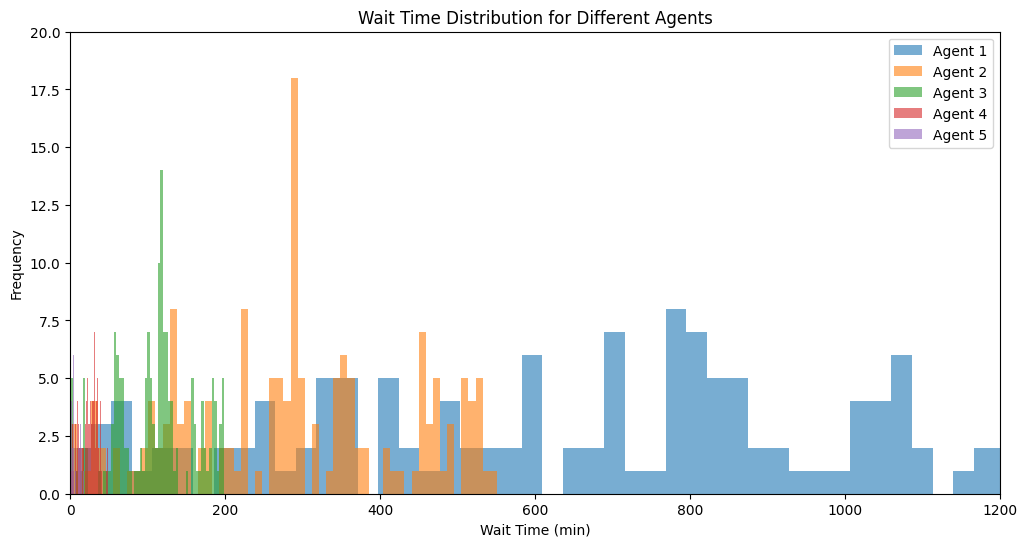

In [30]:
plt.figure(figsize=(12,6))
for s in [1,2,3,4,5]:
    w,j = simulate_time(s)
    plt.hist(w*60, bins=60, alpha=0.6, label=f'Agent {s}')
plt.ylim((0, 20))
plt.xlim((0,1200))
plt.xlabel('Wait Time (min)')
plt.ylabel('Frequency')
plt.title('Wait Time Distribution for Different Agents')
plt.legend()
plt.show()
